# Problem Statement
Environment:   Assume your domain is the x-y plane.   To start, you have the obstacle:  circle with radius = 4 and center = (11,11).

1. Using one of the planners, find (approximately) the shortest path from (9,15) to (15,9).   Plot the domain, the obstacle and the path. 
2. Assume that the path is the end-effector of a two link manipulator with arm lengths a1 = 10 and a2 = 10.    The base of the arm is (0,0).   Feed 5 to 15 of the path points into the inverse kinematics.  Plot the arms, path, and obstacle on the domain.   You may want to only plot 5.   Pick representative plots to show what the arm is doing?   Are there any issues?
3. Write some code to determine what the obstacle looks like in configuration space.  Don't just focus on the end-effector; you also need to consider intermediate link - obstacle collisions.    Plot the obstacle in config space.    Plot the configuration space path on the previous plot.  What happens if you add quadrant 3 as an obstacle?
4. Find the points in config space that correspond to (9,15) and (15,9).   Using the obstacle you just computed.  Find a minimal path between the two computed points.  
4. Following the path you computed in #4, what is the path of the end-effector in the workspace.   Create a second plot that shows some sample arm configurations while moving along the path. 

# Creating the environment

In order to make life easier, I decided to learn how to use the Shapely library to handle the geometric computations. It allows very natural expressions such as `if manipulator.intersects(obstacle):` which we will use extensively later on. It also makes inflating obstacles trivial with the `obstacle.buffer(radius)` command. In fact, we will use that command to create our circle by putting a 4 unit buffer around the point (11,11). We can use the `descartes` library to convert the shapely objects to matplotlib patches that we can plot.

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<IPython.core.display.Javascript object>


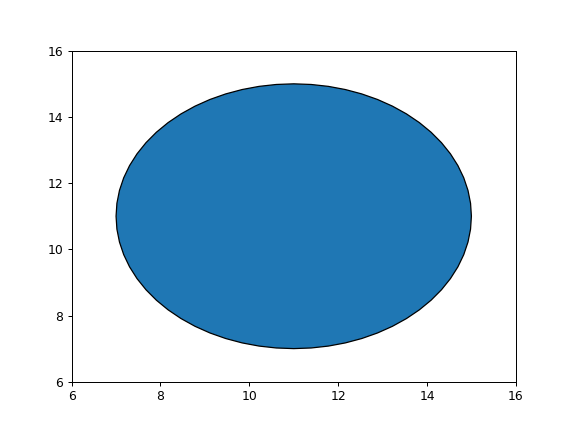

(6.0, 16.0)

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
# plt.rcParams['figure.figsize'] = [10, 5]
import shapely.geometry as geom
import descartes as dc

rect = geom.Polygon([ (8,6),(8,8),(6,8),(6,6)]) 
circle = geom.Point(11,11).buffer(4)

circle_patch = dc.PolygonPatch(circle)

fig,ax = plt.subplots()
ax.add_patch(circle_patch)
ax.set_xlim(6,16)
ax.set_ylim(6,16)

Using one of the planners, find (approximately) the shortest path from (9,15) to (15,9).   Plot the domain, the obstacle and the path. 

# Find a path in the workspace

Our first task is to find the shortest path in the workspace that avoids the obstacle. I copied over my graph generation and A* code from homeworks 1 and 2. Next I created a list containing the start point, the goal point, and all of the obstacle vertices. I was then able to create a visibility graph. For each pair of vertices, I created a line to connect them and checked to see whether that line went through an obstacle. If it didn't, then those two vertices got connected in the graph. For a more complex environment, this approach would probably be untenable because it would take too long, but it is sufficient for this case. Once we have the visibility graph, we can find a path using A* and plot the results

In [2]:
import heapq
import copy

class Node():
    def __init__(self, xy, hfunc):
        self.neighbors = {}
        self.g = np.Inf
        self.xy = np.array(xy)
        self.hfunc = hfunc

    def __lt__(self, other):
        lt = False
        f1 = self.g+self.hfunc(self.xy)
        f2 = other.g+self.hfunc(self.xy)
        if np.abs(f1-f2) < 0.001:
            #print("almost equal")
            lt = self.g > other.g
        else:
            lt = f1 < f2
            
        #lt = f1 < f2
        return lt

    def __eq__(self, other):
        return all(self.xy == other.xy)
    
    def __call__(self):
        return self.hfunc(np.array([self.x, self.y]))
        try:
            return self.f
        except:
            self.f = self.g+self.hfunc(np.array([self.x, self.y]))
            return self.f


class Graph():
    def __init__(self, dist_func):
        self.nodes = {}
        self.dist_func = dist_func
        
    def __iadd__(self, t):
        n1 = t[0]
        n2 = t[1]
        weight = t[2]
        self.connect(n1, n2, weight)
        return graph
        
    def connect(self, n1, n2, weight):
        try:
            self.nodes[n1].neighbors[n2] = weight
        except KeyError:
            self.nodes[n1] = Node(n1, self.hfunc)
            self.nodes[n1].neighbors[n2] = weight
        try:
            self.nodes[n2].neighbors[n1] = weight
        except KeyError:
            self.nodes[n2] = Node(n2,self.hfunc)
            self.nodes[n2].neighbors[n1] = weight

    def draw(self, ax):
        for pt in self.nodes:
            node = self.nodes[pt]
            for neighbor in node.neighbors:
                ax.plot([pt[0],neighbor[0]],[pt[1], neighbor[1]],'k')
                
    def hfunc(self, node):
        return self.dist_func(node, self.goal)
        

def h_l2_dist(node, goal):
    return np.linalg.norm(node-goal)

def a_star(graph, start, goal, max_iter = np.Inf):
    graph = copy.deepcopy(graph)
    start_node = graph.nodes[start[0], start[1]]
    start_node.g = 0

    goal_node = graph.nodes[goal[0], goal[1]]
    graph.goal = goal

    start_node.goal = goal
    Q = [start_node]
    heapq.heapify(Q)
    searched = []
    curr_node = start_node
    count = 0
    while len(Q) > 0 and curr_node != goal_node and count < max_iter:
        curr_node = heapq.heappop(Q)
        count += 1

        searched.append(curr_node.xy)
        for neighbor in curr_node.neighbors:
            weight = curr_node.neighbors[neighbor]
            try:
                other_node = graph.nodes[neighbor]
                if curr_node.g + weight < other_node.g:
                    other_node.g = curr_node.g + weight
                    other_node.prev = curr_node
                    if other_node not in Q:
                        other_node.goal = goal
                        heapq.heappush(Q, other_node)
            except:
                pass
    if len(Q) == 0:
        print("No solution found")
        return graph, np.array([[start_node.x, start_node.y]]), np.array(searched), 0
    path = [curr_node.xy]
    path_cum_length = [0]
    path_length = 0
    while curr_node != start_node:
        path.insert(0, curr_node.prev.xy)
        path_length += np.linalg.norm(curr_node.xy-curr_node.prev.xy)
        path_cum_length.append(path_length)
        curr_node = curr_node.prev

    return graph, np.array(path), np.array(searched), np.array(path_cum_length)

<IPython.core.display.Javascript object>


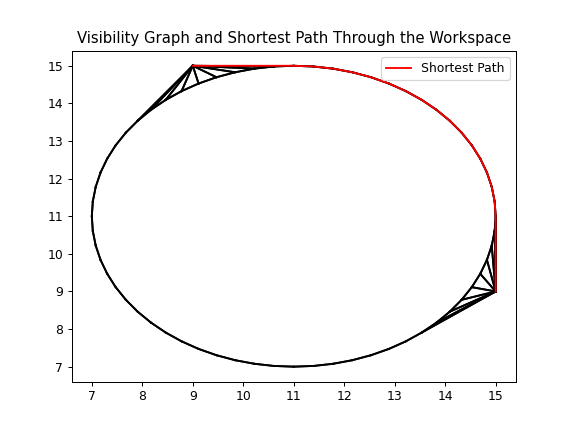

In [3]:
start_pt = (9,15)
goal_pt = (15,9)

graph = Graph(h_l2_dist)

obstacles = [circle]

vertices = [start_pt, goal_pt]
for obs in obstacles:
    vertices += [*obs.boundary.coords]

for p1 in vertices:
    for p2 in vertices:
        l = geom.LineString([p1, p2])

        if not any((l.crosses(obs) or l.within(obs)) for obs in obstacles):
            graph += (p1, p2, np.linalg.norm( np.array(p1)-np.array(p2)))

new_graph, path, searched, path_cum_length = a_star(graph, start_pt, goal_pt)

fig, ax = plt.subplots()
graph.draw(ax)
ax.plot(path[:,0], path[:,1],'r',label='Shortest Path')
plt.title("Visibility Graph and Shortest Path Through the Workspace")
plt.legend()

# Traverse the path with a two link manipulator

Our next task is to show what a two link manipulator would look like in the workspace if it were to follow the path computed above with the end effector. We define two functions to compute the forward and inverse kinematics of the manipulator. The forward kinematics returns a list with a point representing the base, end of link 1 and end of link 2. The inverse kinematics uses a numerical solver to find a set of joint angles that would result in the desired end effector position. We test the forward and inverse kinematics by computing the inverse kinematics for a point, passing the computed joint angles through the forward kinematics and asserting that the resulting point matches the original point. We test the forward kinematics with a few easily computed sets of joint angles involving 0 and 90 degrees, making sure to test all 4 quadrants.

Once we have the forward and inverse kinematics, we can simply iterate through the point on the previously computed path, computing the corresponding joint angles and plotting every third point on the visualization. While we are iterating, we also create a list containing the path in configuration space for later use.

It is clear from the plot that the manipulator is colliding with the obstacle for most of the traversal. We will need to fix that by considering the obstacle in configuration space.

<IPython.core.display.Javascript object>


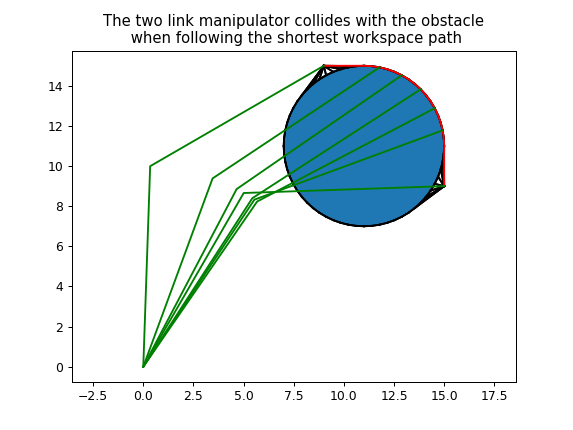

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


Text(0.5, 1.0, 'The two link manipulator collides with the obstacle\n when following the shortest workspace path')

In [4]:
from scipy.optimize import fsolve

a1 = 10
a2 = 10
base = (0,0)

def fk(thetas):
    t1 = thetas[0]
    t2 = thetas[1]
    x1 = a1*np.cos(t1)
    y1 = a1*np.sin(t1)
    
    x2 = x1 + a2*np.cos(t1+t2)
    y2 = y1 + a2*np.sin(t1+t2)
    
    return np.array([(0,0),(x1,y1),(x2,y2)])

def near(a,b):
    return abs(a-b) < 0.0001

# Test straight right
assert(near(fk([0,0])[2][0], 20))
assert(near(fk([0,0])[2][1] , 0))

# Test straight up
assert(near(fk([np.pi/2,0])[2][0] ,0 ))
assert(near(fk([np.pi/2,0])[2][1] , 20))

# Test 90 bend quadrant 1
assert(near(fk([0,np.pi/2])[2][0] , 10))
assert(near(fk([0,np.pi/2])[2][1] , 10))

# Test 90 bend quadrant 2
assert(near(fk([np.pi/2,np.pi/2])[2][0] , -10))
assert(near(fk([np.pi/2,np.pi/2])[2][1] , 10))

# Test 90 bend quadrant 3
assert(near(fk([np.pi,np.pi/2])[2][0] , -10))
assert(near(fk([np.pi,np.pi/2])[2][1] , -10))

# Test 90 bend quadrant 4
assert(near(fk([3*np.pi/2,np.pi/2])[2][0] , 10))
assert(near(fk([3*np.pi/2,np.pi/2])[2][1] , -10))

def ik(xy, t_guess=np.array((0,0))):
    def diff(thetas):
        base, j1, j2 = fk([thetas[0], thetas[1]])
        return j2 - xy
    res = fsolve(diff, t_guess)
    return res



# Test inverse kinematics
test_pt = [0.5, 0.2]
test_thetas = ik(test_pt)
base, j1, j2 = fk(test_thetas)
assert(near(j2[0],test_pt[0]))
assert(near(j2[1],test_pt[1]))




thetas = np.array([0,0])
bases = []
j1s = []
j2s = []

fig, ax = plt.subplots()
patches = []
for obs in obstacles:
    patch = dc.PolygonPatch(obs)
    patches.append(patch)
    ax.add_patch(patch)
ax.set_xlim(0,16)
ax.set_ylim(0,16)
graph.draw(ax)
ax.plot(path[:,0],path[:,1],'r')
path_q = []
for i in range(0,len(path),3):
    pt = path[i]
    thetas = ik(pt,thetas)
    path_q.append(thetas)
    joints = fk(thetas)
    ax.plot(joints[:,0],joints[:,1],'g')

ax.axis('equal')
path_q = np.array(path_q)
plt.title("The two link manipulator collides with the obstacle\n when following the shortest workspace path")

    

Write some code to determine what the obstacle looks like in configuration space.  Don't just focus on the end-effector; you also need to consider intermediate link - obstacle collisions.    Plot the obstacle in config space.    Plot the configuration space path on the previous plot.  What happens if you add quadrant 3 as an obstacle?

# Visualize the obstacle in configuration space

I tried multiple approaches to visualizing the obstacle in configuration space. Some of the work is included at the end of this notebook as an addendum for the interested reader. 

My first thought was to compute some function that maintains a value of zero when the manipulator is just barely touching the obstacle and a non-zero value elsewhere. This function could then be differentiated and the boundary of the obstacle could be traversed by solving the differential equation corresponding to the null space of the Jacobian. In order to accomplish this, I wrote my own autodifferentiation class and created a mathematical function for which this process worked if the obstacle was a single point. This was taking a lot of time to develop, however, so I paused the effort part way through trying to extend it to work for an obstacle consisting of a single straight line.

My next approach was to iteratively find the boundary by a sequence of step-like motions of the arm as follows:

* start with the arm straight out
* move joint 1 until the arm collides
* move joint 2 until the arm is not colliding
* record this point as part of the boundary
* repeat until one of the arms goes full circle
* swap the direction of motion of the appropriate joint
* repeat until you get back to where you started

In configuration space, this is tantamount to the following:

* step right until we collide with the boundary
* step down until we are free
* repeat until we reach the bottom of the obstacle
* step up then right until we find the right edge of the obstacle
* step left then up until we find the top edge of the obstacle
* step down then left until we find the left edge
* step right then down until we get to the starting point again

I was able to make this approach work for the case of an obstacle that will never touch the first link. I was then able to extend it to handle an obstacle that can impact the first link. At first it seemed fine, but as I tried more edge cases such as an obstacle consisting of quadrant 3 or an obstacle that impacts the starting position of the algorithm, the code became harder and harder to understand. 

I was trying to find a way to reformulate the algorithm to be more easily understood when I realized that the bug 1 algorithm would be perfect for this application. We want to travel until we find an obstacle and then follow the wall until we have gone all the way around. I then grabbed my bug 1 code from homework 1 and modified it to work for this case. This algorithm is far easier to understand and the code is much more intuitive as well.

The modified Bug 1 algorithm is implemented as a finite state machine with the following states:

* init
    * start at (0,0) in config space
    * go right until in free space
    * state = goal
* goal
    * go right until you hit an obstacle
    * state = wall_start
* wall_start
    * turn left until parallel to the wall
    * record location as wall_start_pos
    * state = wall
* wall
    * follow the wall
    * if you get back to wall_start_pos then you have traversed the whole boundary so move on to the next obstacle
        * state = cross_obstacle_then_goal
    * if you travel 2*$\pi$ units straight up then the obstacle will continue forever and we need to cross it and go down the other side
        * state = cross_obstacle_then_wall
    * if you travel 2*$\pi$ unit straight down then we just finished coming down the other side after crossing the obstacle
        * state = goal
* cross_obstacle_then_wall
    * go right
    * if you hit free space
        * state = wall_start
* cross_obstacle_then_goal
    * go right
    * if you hit free space
        * state = goal
        
Obstacles that intersect with link 1 will show up as infinitely tall walls in configuration space because there is no value of $\theta_2$ that will allow you to cross the obstacle. For this reason, if we detect that the obstacle is an infinite wall, we cross the obstacle and follow the wall on the other side. This approach to finding the obstacles creates closed loops for all the obstacles that can be duplicated at multiples of 2*$\pi$ to give a clear picture of the configuration space.

I did find one edge case that will break this algorithm if you try to traverse a set of disjoint obstacles in the workspace that actually map to a single obstacle in the configuration space. In this case it's possible (though not guaranteed) to get an infinite loop. Traversing each obstacle individually works just fine, so that's my workaround. It might be possible to create a single obstacle that behaves the same way, but I think it's unlikely for such an obstacle to exist. I spent some time trying to fix this case in the algorithm but I kept breaking other things and it didn't seem like a high priority so I shelved it.

In [5]:
def turn_left_till_free(pos, theta, ds, obs):
    dir_vec = np.array([np.cos(theta), np.sin(theta)])
    new_pos = pos + dir_vec*ds
    # turn left until we see free space
    while collision(new_pos, obs):
        time_since_collision = 0
        theta += 0.1
        dir_vec = np.array([np.cos(theta), np.sin(theta)])
        new_pos = pos + dir_vec*ds
        # ax2.plot(new_pos[0], new_pos[1], 'g.')
    return theta


def turn_right_till_wall(pos, theta, ds, obs):
    dir_vec = np.array([np.cos(theta), np.sin(theta)])
    new_pos = pos + dir_vec*ds
    # turn left until we see free space
    while not collision(new_pos, obs):
        time_since_collision = 0
        theta -= 0.1
        dir_vec = np.array([np.cos(theta), np.sin(theta)])
        new_pos = pos + dir_vec*ds
        # ax2.plot(new_pos[0], new_pos[1], 'r.')
    return theta


def step_forward(pos, theta, ds, path_length):
    dir_vec = np.array([np.cos(theta), np.sin(theta)])
    new_pos = pos + dir_vec*ds
    pos = new_pos
    path_length += ds
    if path_length > 100:
        raise RuntimeError
    return pos, path_length


def collision(thetas, obstacle):
    joints = fk(thetas)
    manipulator = geom.LineString(joints)
    return manipulator.intersects(obstacle)


def find_boundary(obs):
    pos = np.array([0., 0.])
    goal_pt = np.array([2*np.pi, 0])
    mode = "init"
    ds = 0.1
    path_length = 0
    theta = 0
    prev_mode = "none"
    while np.linalg.norm(pos-goal_pt) > ds:
        should_yield = True
        if mode != prev_mode:
            # print("mode: {} -> {}, {}, {}".format(prev_mode, mode, pos, pos-goal_pt))
            prev_mode = mode

        if mode == "goal":
            should_yield = False
            dir_vec = np.array([1, 0])
            theta = 0
            new_pos = pos + dir_vec*ds

            if collision(new_pos, obs):
                mode = "wall_start"

            else:
                pos, path_length = step_forward(
                    pos, theta, ds, path_length)
        elif mode == "wall_start":
            theta = turn_right_till_wall(pos, theta, ds, obs)
            theta = turn_left_till_free(pos, theta, ds, obs)
            wall_start_pos = pos
            pos, path_length = step_forward(
                pos, theta, ds*1.1, path_length)
            mode = "wall"
        elif mode == "wall":
            theta = turn_left_till_free(pos, theta, ds, obs)
            theta = turn_right_till_wall(pos, theta, ds, obs)
            theta += 0.1
            old_pos = pos.copy()
            pos, path_length = step_forward(pos, theta, ds, path_length)

            curr_dist = np.linalg.norm(pos-goal_pt)

            if np.linalg.norm(pos-wall_start_pos) < ds:
                mode = "cross_obstacle_then_goal"
            if np.linalg.norm(pos - np.array([0, 2*np.pi+ds]) - wall_start_pos) < ds:
                pos = wall_start_pos + np.array([0, 2*np.pi+ds])
                mode = "cross_obstacle_then_wall"
            if np.linalg.norm(pos + np.array([0, 2*np.pi+ds]) - wall_start_pos) < ds:
                pos = wall_start_pos - np.array([0, 2*np.pi+ds])
                mode = "goal"
        elif mode == "cross_obstacle_then_wall":
            theta = 0
            dir_vec = np.array([1, 0])
            new_pos = pos + dir_vec*ds

            pos, path_length = step_forward(pos, theta, ds, path_length)
            if not collision(pos, obs):
                mode = "wall_start"
        elif mode == "cross_obstacle_then_goal":
            should_yield = False
            theta = 0
            dir_vec = np.array([1, 0])
            new_pos = pos + dir_vec*ds

            pos, path_length = step_forward(pos, theta, ds, path_length)

            if not collision(pos, obs):
                mode = "goal"
        elif mode == "init":
            should_yield = False
            theta = 0
            dir_vec = np.array([1, 0])
            new_pos = pos + dir_vec*ds

            pos, path_length = step_forward(pos, theta, ds, path_length)
            if not collision(pos, obs):
                mode = "goal"
                goal_pt = np.array([new_pos[0]+2*np.pi, 0])
        if should_yield:
            yield pos

In [6]:
circle = geom.Point(11, 11).buffer(4)
quad_3 = geom.Polygon(np.array(
    [[-0.000001, -0.000001], [-21, -0.000001], [-21, -21], [-0.0000001, -21]]))
circle_2 = geom.Point(5, 5).buffer(4)
circle_3 = geom.Point(5, 0).buffer(1)

## Animate the boundary traversal

The following section provides an animation of what the boundary traversal looks like in both the workspace and the configuration space. A few sample obstacles are provided and can be visualized by uncommenting the appropriate line of code.

<IPython.core.display.Javascript object>


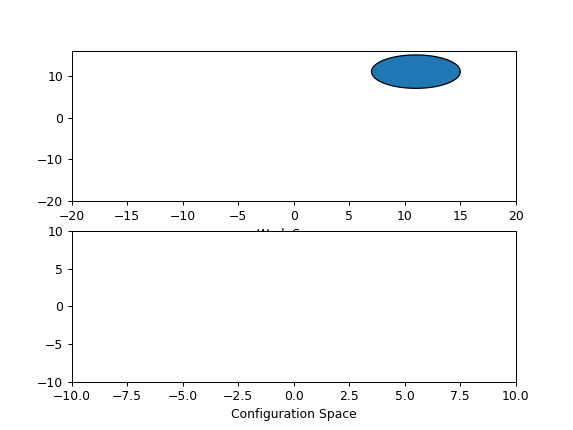

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


In [7]:
boundary_t1 = []
boundary_t2 = []
def anim_func(data):
    pos = data
    boundary_t1.append(pos[0])
    boundary_t2.append(pos[1])
    joints = fk(pos)
    l1.set_data(joints[:, 0], joints[:, 1])
    p2.set_data(pos[0], pos[1])
    l2.set_data(boundary_t1, boundary_t2)


# Uncomment one of the following to have the animation traverse a different test obstacle
obs = circle
# obs = quad_3 # An obstacle representing quadrant 3
# obs = circle_2 # A circular obstacle that touches link 1
# obs = circle_3 # A circular obstacle that touches the arm at (0,0)
fig, [ax1, ax2] = plt.subplots(2, 1)
patch = dc.PolygonPatch(obs)
ax1.add_patch(patch)

l1, = ax1.plot([], [], 'b')
l2, = ax2.plot([], [])
p2, = ax2.plot([], [], 'k.')

ax1.set_xlim(-20, 20)
ax1.set_ylim(-20, 16)
ax1.set_xlabel("Work Space")
# ax1.axis('equal')

ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2.set_xlabel("Configuration Space")

y = find_boundary(obs)
animation = anim.FuncAnimation(fig, anim_func, y, interval=50)
plt.show()

## Illustrate the workspace path in configuration space

The following section shows what the path around the circular obstacle would look like if converted to configuration space. As expected, the path intersects an obstacle for most of the traversal.

<IPython.core.display.Javascript object>


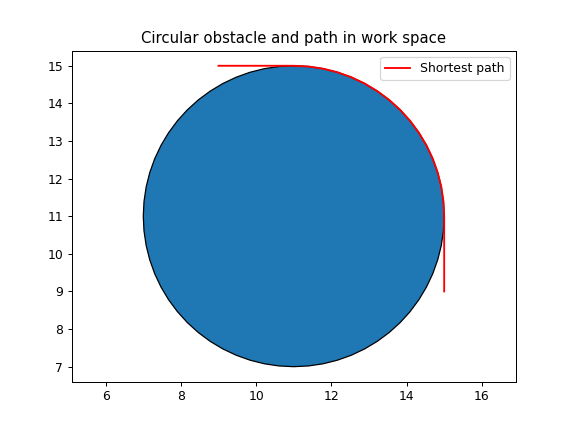

<IPython.core.display.Javascript object>


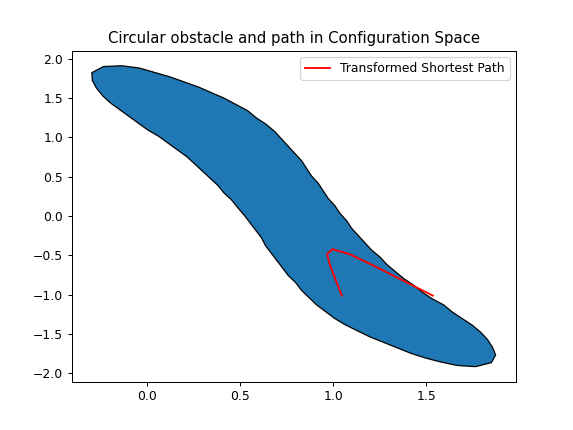

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


In [8]:
thetas = np.array([0,0])
bases = []
j1s = []
j2s = []

fig, ax = plt.subplots()
patches = []
for obs in obstacles:
    patch = dc.PolygonPatch(obs)
    patches.append(patch)
    ax.add_patch(patch)
ax.set_xlim(0,16)
ax.set_ylim(0,16)
ax.plot(path[:,0],path[:,1],'r', label="Shortest path")

ax.axis('equal')
path_q = np.array(path_q)
plt.title("Circular obstacle and path in work space")
plt.legend()

obstacles = [circle]

boundary_pts = []
for obs in obstacles:
    y = find_boundary(obs)
    boundary = [pos for pos in y]
    boundary_pts.append(np.array(boundary))

# offsets = [2*np.pi, 0, -2*np.pi]
offsets = [0]
fig, ax = plt.subplots()
n = 2
# plt.xlim([-n*np.pi, n*np.pi])
# plt.ylim([-n*np.pi, n*np.pi])
for boundary in boundary_pts:
    for x_offset in offsets:
        for y_offset in offsets:
            new_bound = np.array(
                [boundary[:, 0]+x_offset, boundary[:, 1]+y_offset]).T
            polygon = geom.Polygon(new_bound)
            patch = dc.PolygonPatch(polygon)
            ax.add_patch(patch)

ax.plot(path_q[:,0], path_q[:,1],'r',label="Transformed Shortest Path")
plt.title("Circular obstacle and path in Configuration Space")
plt.legend()



# Visualize circle and quadrant 3 obstacles

The next goal is to examine what the configuration space would look like if quadrant 3 in the work space was inaccessible. We can use exactly the same algorithms from before to compute the boundary. When plotting, I have duplicated the obstacles at multiples of 2*$\pi$ in order to illustrate the nature of the space more fully. As expected, quadrant 3 forms a vertical wall in configuration space meaning that $\theta_1$ is restricted while $\theta_2$ can spin freely when far enough from the obstacle

<IPython.core.display.Javascript object>


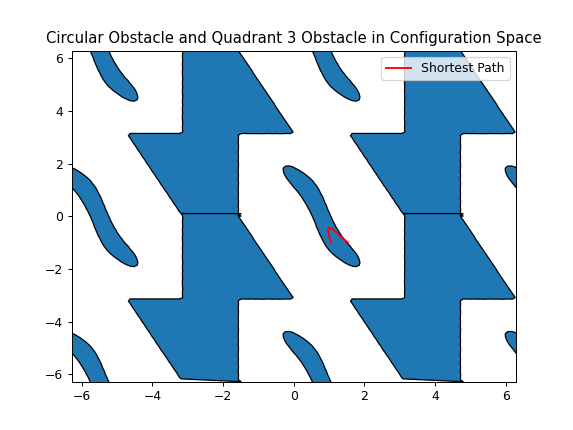

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


In [9]:
obstacles = [circle, quad_3]

boundary_pts = []
for obs in obstacles:
    y = find_boundary(obs)
    boundary = [pos for pos in y]
    boundary_pts.append(np.array(boundary))

offsets = [2*np.pi, 0, -2*np.pi]
# offsets = [0]
fig, ax = plt.subplots()
n = 2
plt.xlim([-n*np.pi, n*np.pi])
plt.ylim([-n*np.pi, n*np.pi])
for boundary in boundary_pts:
    for x_offset in offsets:
        for y_offset in offsets:
            new_bound = np.array(
                [boundary[:, 0]+x_offset, boundary[:, 1]+y_offset]).T
            polygon = geom.Polygon(new_bound)
            patch = dc.PolygonPatch(polygon)
            ax.add_patch(patch)

ax.plot(path_q[:,0], path_q[:,1],'r',label="Shortest Path")
plt.title("Circular Obstacle and Quadrant 3 Obstacle in Configuration Space")
plt.legend()

Find the points in config space that correspond to (9,15) and (15,9).   Using the obstacle you just computed.  Find a minimal path between the two computed points.  

Following the path you computed in #4, what is the path of the end-effector in the workspace.   Create a second plot that shows some sample arm configurations while moving along the path. 

# Find collision-free path

## Illustrate start and goal in configuration space

The first task in finding a collision-free path is to convert the start point and goal point to the configuration space. There are multiple solutions for both start and goal. We can find them both by providing appropriate initial values to the inverse kinematics solver. The figure below shows the possible start and goal points. Since only one start point and one goal point lie in free space, we will use those two points when computing the path. 

<IPython.core.display.Javascript object>


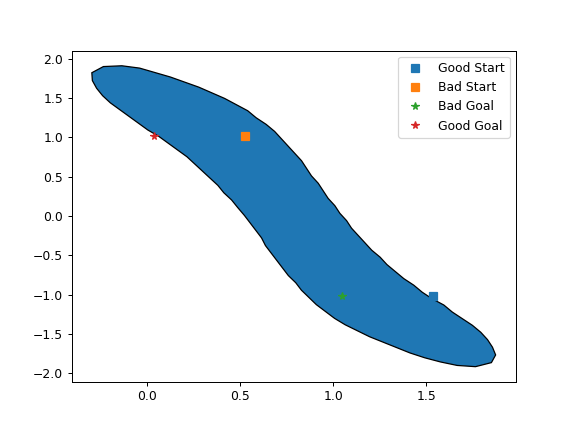

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


In [10]:
from scipy.interpolate import interp1d

graph = Graph(h_l2_dist)



y = find_boundary(circle)
circle_boundary = np.array([pos for pos in y])
circle_q = geom.Polygon(circle_boundary)

fig, ax = plt.subplots()
circle_q_patch = dc.PolygonPatch(circle_q)
ax.add_patch(circle_q_patch)

start_thetas_1 = tuple(ik(start_pt))
guess = (start_thetas_1[0] + 2* start_thetas_1[1], -start_thetas_1[1])
start_thetas_2 = tuple(ik(start_pt, guess))

if geom.Point(start_thetas_1).intersects(circle_q):
    ax.plot(start_thetas_1[0], start_thetas_1[1],'s', label="Bad Start")
    ax.plot(start_thetas_2[0], start_thetas_2[1],'s', label="Good Start")
    start_thetas = start_thetas_2
else:
    ax.plot(start_thetas_1[0], start_thetas_1[1],'s', label="Good Start")
    ax.plot(start_thetas_2[0], start_thetas_2[1],'s', label="Bad Start")
    start_thetas = start_thetas_1
    

goal_thetas_1 = tuple(ik(goal_pt))
guess = (goal_thetas_1[0] + 2*goal_thetas_1[1], -goal_thetas_1[1])
goal_thetas_2 = tuple(ik(goal_pt, guess))

if geom.Point(goal_thetas_1).intersects(circle_q):
    ax.plot(goal_thetas_1[0], goal_thetas_1[1], '*', label="Bad Goal")
    ax.plot(goal_thetas_2[0], goal_thetas_2[1], '*', label="Good Goal")
    goal_thetas = goal_thetas_2
else:
    ax.plot(goal_thetas_1[0], goal_thetas_1[1], '*', label="Good Goal")
    ax.plot(goal_thetas_2[0], goal_thetas_2[1], '*', label="Bad Goal")
    goal_thetas = goal_thetas_1
    
plt.legend()


## Convert to a graph and find shortest path

We can convert the configuration space to a graph exactly the same way that we did in the workspace. Make a list of all the vertices including the start and end point. Then iterate through each pair of vertices and add an edge to the graph if the vertices are visible to each other. We can then use our A* algorithm to compute the shortest path through configuration space. The figures below show the shortest path through configuration space and also the corresponding path that the manipulator would take through the work space. As expected, it just barely skirts the edge of the obstacle and switches from an elbow down to elbow up configuration. 

In [11]:
obstacles_q = [circle_q]

vertices = [start_thetas, goal_thetas]
for obs in obstacles_q:
    vertices += [*obs.boundary.coords]
    
graph = Graph(h_l2_dist)
for i in range(len(vertices)):
    p1 = vertices[i]
    for j in range(i):
        p2 = vertices[j]
        l = geom.LineString([p1, p2])

        if not any((l.crosses(obs) or l.within(obs)) for obs in obstacles_q):
            graph += (p1, p2, np.linalg.norm( np.array(p1)-np.array(p2)))

<IPython.core.display.Javascript object>


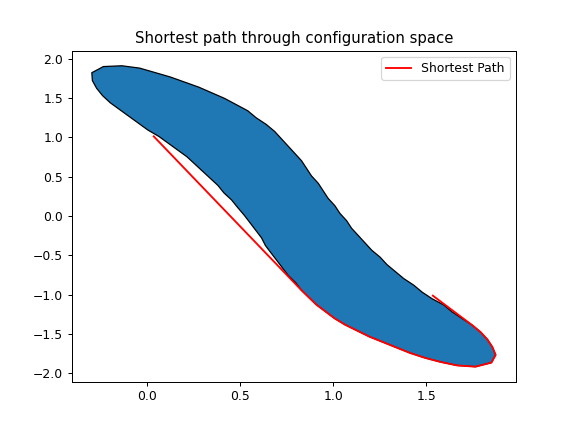

<IPython.core.display.Javascript object>


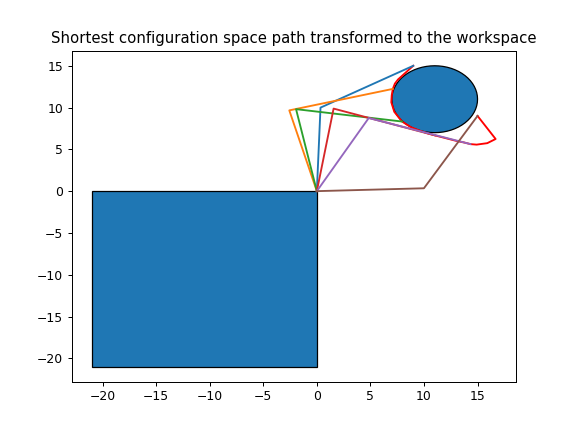

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


Text(0.5, 1.0, 'Shortest configuration space path transformed to the workspace')

In [12]:
new_graph, path_q, searched, path_cum_length_q = a_star(graph, start_thetas, goal_thetas)

fig, ax = plt.subplots()
circle_q_patch = dc.PolygonPatch(circle_q)
ax.add_patch(circle_q_patch)
# graph.draw(ax)
ax.plot(path_q[:,0], path_q[:,1],'r',label='Shortest Path')
plt.legend()
plt.title('Shortest path through configuration space')
fig2, ax2 = plt.subplots()

patches = []
for obs in obstacles:
    patch = dc.PolygonPatch(obs)
    patches.append(patch)
    ax2.add_patch(patch)
    
path = []
for pt in path_q:
    path.append(fk(pt))
path = np.array(path)

ax2.plot(path[:,2,0],path[:,2,1],'r')
joints = path[0]
ax2.plot(joints[:,0],joints[:,1],label='0')
last_plotted = joints
for i in range(1,len(path)):
    joints = path[i]
    if np.linalg.norm(joints[2]-last_plotted[2]) > 3:
        ax2.plot(joints[:,0],joints[:,1], label=str(i))
        last_plotted = joints
plt.title("Shortest configuration space path transformed to the workspace")

# Conclusion

By representing obstacles in configuration space, we can plan complicated paths through the workspace that will avoid obstacles. This process involves using some sort of sampling method to represent the obstacle in configuration space followed by converting that representation to a graph which can be traversed using A*. I came up with an algorithm that explored the boundary of the obstacle rather than sampling the whole obstacle. I feel like this approach should have benefits in terms of performance because it scales with the length of the boundary, instead of with the area of the obstacle. I haven't benchmarked it against any other approaches so it's hard to say. In all, it's effective and was fun to develop.

# Addendum: Using the null space

The following section represents my first attempt to skirt the edge of an obstacle by traversing the null space of the jacobian of a specially defined function. I made it work for a point-shaped obstacle, but abandoned the effort partway through extending it to work for a line.

In order to simplify the solution to start with, I'm only going to consider intersections with the second link. For this problem, that is totally adequate because the obstacle will never touch the first link. We can parameterize the intersection point on the second arm by creating an auxiliary variable, $s$ that will vary between 0 and 1. When $s=0$ the point will be at the joint between arms 1 and 2. When $s=1$, the point will be at the end effector. With this approach, we can define any point within the workspace, $q$, with the following equations:

$$ p_1 = \left< a_1 cos(\theta_1), a_1 sin(\theta_1) \right> $$
$$ p_2 = p_1 + \left< a_2 cos(\theta_1 + \theta_2), a_2 sin(\theta_1 + \theta_2)\right> $$
$$ q(\theta_1, \theta_2, s) = s \cdot p_2 + (1-s)\cdot p_1 $$

For a given point, $q$, we can now define all the configurations that intersect with that point as the set of $\theta_1$, $\theta_2$, $0<=s<=1$ that solves the above equation.

Once we have found one solution to this equation, we can discover others by perturbing $\theta_1$, $\theta_2$, and $s$ such that the total derivative of q with respect to time is zero. The Jacobian represents the partial derivatives of this equation with respect to each of the independent variables, thus the nullspace of the Jacobian represents the direction in which we should travel in order to hold $q$ constant while varying the independent variables. Put another way, we want to solve the following differential equation:
$$ \frac{\partial q}{\partial \theta_1} \frac{d\theta_1}{d t} + \frac{\partial q}{\partial \theta_2} \frac{d\theta_2}{d t} + \frac{\partial q}{\partial s} \frac{ds}{d t} = 0$$

to find $\theta_1(t)$, $\theta_2(t)$, and $s(t)$

Thankfully this is easily done numerically using the `scipy.integrate.solve_ivp()` function which will numerically solve an initial value problem. We simply have to define a function which takes in the state, $[\theta_1, \theta_2, s]$ and returns $[\dot \theta_1, \dot \theta_2, \dot s]$.

In order to avoid computing a bunch of partial derivatives by hand, in the following section I create an autodifferentiation class compatible with numpy. Once that has been done, I define the `fk_arm()` function to do the forward_kinematics according to the definition of $q$ above. The `fk_arm_jac()` function then uses the autodifferentiation class to compute the Jacobian of $q$. Finally, the `null_deriv()` function computes the nullspace of the Jacobian, correcting for sign flips, and allowing either forward or backward traversal via the `direction` argument.

Once all that has been defined, we can pass `null_deriv()` to the solve_ivp function to traverse the level set. We also define the `reached_p1()` and `reached_p2()` functions to enable solve_ivp to terminate when it has traversed all the way to the end of the arm.

/tmp/ipykernel_21057/4238759359.py:60: RuntimeWarning: divide by zero encountered in log
  newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)
/tmp/ipykernel_21057/4238759359.py:60: RuntimeWarning: invalid value encountered in double_scalars
  newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)
/tmp/ipykernel_21057/4238759359.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)


<IPython.core.display.Javascript object>


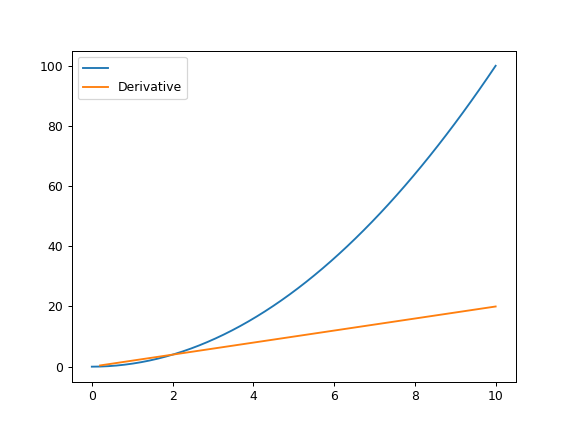

In [13]:
import numpy as np

class D:
    
    def __init__(self, v, d=0):
        self.v = v
        self.d = d
        
    def __add__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = self.v + other.v
        newd = self.d + other.d
        
        return D(newv, newd)
    def __radd__(self, other):
        
        return self.__add__(other) 
    
    def __mul__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = self.v * other.v
        newd = self.v*other.d + self.d*other.v
        
        return D(newv, newd)
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __sub__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = self.v - other.v
        newd = self.d - other.d
        
        return D(newv, newd)
    
    def __rsub__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = other.v - self.v
        newd = other.d - self.d
        
        return D(newv, newd)
    
    def __pow__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = self.v**other.v
        newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)
        
        return D(newv, newd)
    
    def __str__(self):
        return "({},{})".format(self.v, self.d)
    
    def __repr__(self):
        return self.__str__()
    
    def sin(self):
        newv = np.sin(self.v)
        newd = np.cos(self.v)*self.d
        
        return D(newv,newd)
    
    def cos(self):
        newv = np.cos(self.v)
        newd = -np.sin(self.v)*self.d
        return D(newv, newd)
    
    def sqrt(self):
        newv = np.sqrt(self.v)
        newd = 0.5* self.d/newv
        return D(newv, newd)
    
x = np.array([D(i,1) for i in np.linspace(0,10)])

y = x**2
# y = np.sin(x)

plt.figure()
plt.plot([i.v for i in x],[i.v for i in y], label=' ')
plt.plot([i.v for i in x], [i.d for i in y], label='Derivative')
plt.legend()



<IPython.core.display.Javascript object>


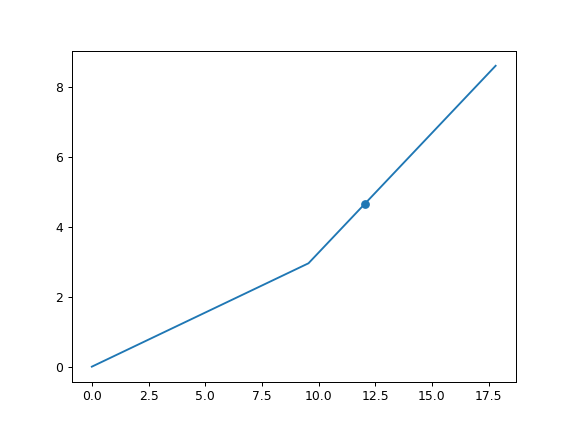

In [14]:
from scipy.integrate import solve_ivp
from scipy.linalg import null_space

def fk_arm(data):
    t1 = data[0]
    t2 = data[1]
    s = data[2]
    #s = -0.5*np.cos(data[2])+0.5
    
    p1 = np.array([a1*np.cos(t1), a1*np.sin(t1)])
    p2 = p1 + np.array([a2*np.cos(t1+t2), a2*np.sin(t1+t2)])
    
    return p1*(1-s) + p2*s

def fk_arm_jac(data):
    J = []
    for i in range(len(data)):
        newdata = []
        for j in range(len(data)):
            temp = D(data[j])
            if i == j:
                temp.d = 1
            else:
                temp.d = 0
            newdata.append(temp)
        dpdi = fk_arm(newdata)
        J.append([dp.d for dp in dpdi])
    return np.array(J).T

def null_deriv(t, data, direction):
    J = fk_arm_jac(data)
    ns = null_space(J)[:,0]
    ns *= np.sign(ns[0])
    if direction == 'f':
        return ns
    else:
        return -ns

data = [0.3, 0.3, 0.3]
p = fk_arm(data)
joints = fk(data)

plt.figure()
plt.plot(joints[:,0], joints[:,1])
plt.scatter(p[0], p[1])

def reached_p1(t,data, direction):
    return data[2]
reached_p1.terminal = True

def reached_p2(t,data, direction):
    return data[2] - 1
reached_p2.terminal = True

t_f = 7
data0 = np.array([*ik(p), 0.9999])
res = solve_ivp(null_deriv, (0,t_f), data0, args=("b"), t_eval=np.arange(0,t_f,0.02), events=(reached_p1, reached_p2))

<IPython.core.display.Javascript object>


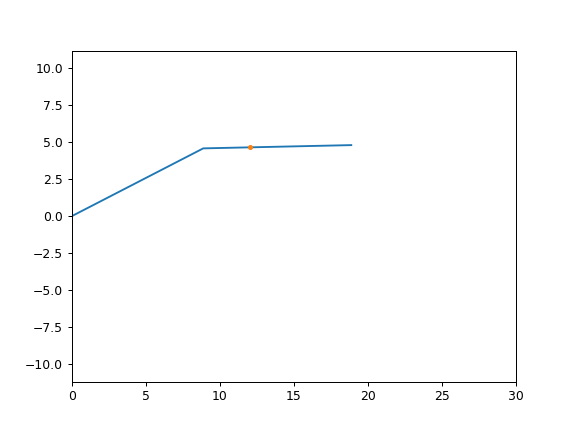

In [15]:
fig, ax = plt.subplots()

joints = fk(res.y.T[0])
l1, = ax.plot(joints[:,0],joints[:,1])
p1, = ax.plot(p[0],p[1],'.')

ax.axis('equal')
ax.set_ylim(-20,20)
ax.set_xlim(0,30)


def anim_func(i):
    print(i)
    data = res.y.T[i]
    joints = fk(data)
    p = fk_arm(data)
    l1.set_data(joints[:,0], joints[:,1])
    p1.set_data(p[0],p[1])

    return l1, p1

func = anim.FuncAnimation(fig, anim_func, frames=len(res.y.T),interval=20)
plt.show()

<IPython.core.display.Javascript object>


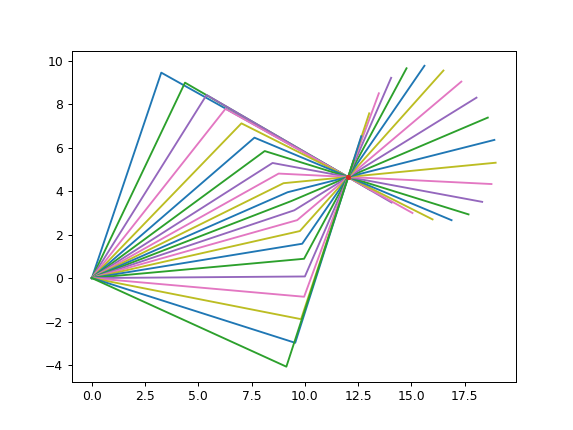

In [16]:
def draw_manipulator(data, ax):
    joints = fk(data)
    p = fk_arm(data)
    l1 = ax.plot(joints[:,0],joints[:,1])
    p1 = ax.plot(p[0],p[1],'.')

fig, ax = plt.subplots()
for i in range(0,len(res.y.T), 10):
    data = res.y.T[i]
    draw_manipulator(data, ax)
    

Now we will try to extend the previous work to trace out the edge of a shape with the manipulator. We will assume a single convex obstacle to begin with and reduce the scope even further to be only two connected edges on the convex obstacle. This should then be extensible to an iterative approach that considers three sequential vertices along the edge of the convex obstacle. The three points we will choose are (5,20), (10,7.5), and (20,12). These points will guarantee that the manipulator has to contact both with the edge of the link and with the end-effector while traversing the obstacle.

<IPython.core.display.Javascript object>


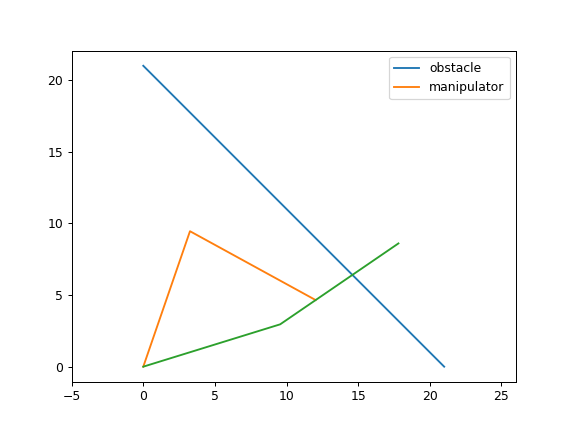

(-1.05, 22.05, -1.05, 22.05)

In [17]:
fig, ax = plt.subplots()

obs_pts = np.array([[21,0],[0,21]])
obs, = ax.plot(obs_pts[:,0], obs_pts[:,1], label='obstacle')
ax.plot(joints[:,0],joints[:,1], label='manipulator')
plt.legend()
plt.axis('equal')

## Extending to traverse a straight line

I never actually got this to work, but the beginning of my approach is below

To traverse a straight line with the end-effector, we can parameterize a point along the obstacle with the two endpoints as follows:

$$ p_l = q_1 \cdot (1-r) + q_2 \cdot r $$

This must be equal to the position of the end effector:

$$ p_1 = \left< a_1 cos(\theta_1), a_1 sin(\theta_1) \right> $$
$$ p_2 = p_1 + \left< a_2 cos(\theta_1 + \theta_2), a_2 sin(\theta_1 + \theta_2)\right> $$

Setting them equal and moving everything to the left hand side, we get the following equation:

$$ q(\theta_1, \theta_2, r) = p_2 - p_l = 0 $$

Just as before we can compute the Jacobian and travel in the direction of the null-space in order to move along the boundary.

<IPython.core.display.Javascript object>


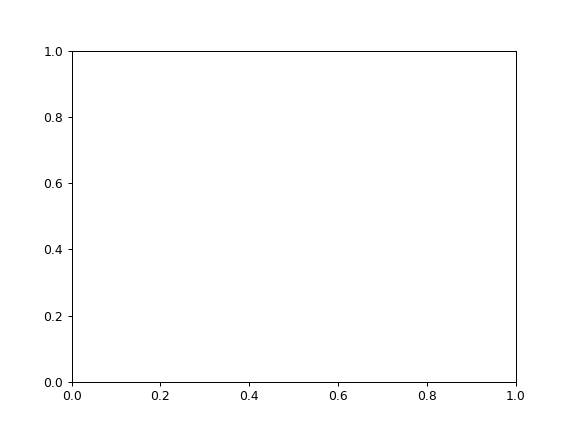

AttributeError: 'numpy.ndarray' object has no attribute 'x'

In [18]:
from scipy.optimize import minimize

q1 = np.array([0,21])
q2 = np.array([21,0])
def fk_end(data):
    t1 = data[0]
    t2 = data[1]
    r = data[2]
    pl = q1*(1-r) + q2*r
#     print("t1:{}".format(t1))
#     print("pl:{}".format(pl))
    p1 = np.array([a1*np.cos(t1), a1*np.sin(t1)])
    p2 = p1 + np.array([a2*np.cos(t1+t2), a2*np.sin(t1+t2)])
    print("p2:{}".format(p2))
    print("pl:{}".format(pl))

    ret = (pl-p2)**2
    print("ret:{}".format(ret))
    ret = np.sum(ret)
    print("retsum:{}".format(ret))
    ret = np.sqrt(ret)
    print("retsqrt:{}".format(ret))
    return ret
#     return np.linalg.norm(pl-p2)

# def ik_end(xy, t_guess=np.array((0,0))):
#     def diff(thetas):
        
#         return j2 - xy
#     res = fsolve(diff, t_guess)
#     return res

def fk_end_jac(data):
    J = []
    for i in range(len(data)):
        newdata = []
        for j in range(len(data)):
            temp = D(data[j])
            if i == j:
                temp.d = 1
            else:
                temp.d = 0
            newdata.append(temp)
        dpdi = fk_end(newdata)
        J.append(dpdi.d)
    return np.array(J).T

def null_end_deriv(t, data, direction):
    J = fk_end_jac(data)
    ns = null_space(J)[:,0]
    ns *= np.sign(ns[0])
    if direction == 'f':
        return ns
    else:
        return -ns

data = [0.3, 0.3, 0.3]
joints = fk(data)

plt.plot(joints[:,0], joints[:,1])

# data0 = minimize(fk_end, x0 = [np.pi/2,0.2, 0.5])
# print(data0)
fig, ax = plt.subplots()
joints = fk(data0.x)
obs_pts = np.array([[21,0],[0,21]])
obs, = ax.plot(obs_pts[:,0], obs_pts[:,1], label='obstacle')
ax.plot(joints[:,0],joints[:,1], label='manipulator')

print(fk_end_jac(data0.x))
print(null_end_deriv(0,data0.x,'f'))

t_f = 7
res = solve_ivp(null_end_deriv, (0,t_f), data0.x, args=("b"), t_eval=np.arange(0,t_f,0.02))
print(res)

In [ ]:
fig, ax = plt.subplots()

joints = fk(res.y.T[0])
l1, = ax.plot(joints[:,0],joints[:,1])
obs_pts = np.array([[21,0],[0,21]])
obs, = ax.plot(obs_pts[:,0], obs_pts[:,1], label='obstacle')

ax.axis('equal')
ax.set_ylim(-20,20)
ax.set_xlim(0,30)


def anim_func(i):
    print(i)
    data = res.y.T[i]
    joints = fk(data)
    l1.set_data(joints[:,0], joints[:,1])
    

    return l1

func = animation.FuncAnimation(fig, anim_func, frames=len(res.y.T),interval=20)
plt.show()